In [39]:
# importing the libraries and files
from collections import Counter, defaultdict
from functools import reduce
import ast
import numpy as np

import geopandas as gpd
import networkx as nx
from itertools import combinations

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats
from scipy.interpolate import interp1d
import seaborn as sns
from statsmodels.stats import diagnostic

from src.data.utils import get_franchise_movies, get_franchise_data, clean_character_metadata, custom_autopct, get_inflation_rate, get_movie, get_genre_counts

# setting the color theme for the plots
sns.set_theme(style='darkgrid', palette='colorblind', color_codes=True)

ImportError: cannot import name 'get_genre_counts' from 'src.data.utils' (/Users/maylismuller/Desktop/EPFL_DOCS/Master/MA1/ADA/ada-2024-project-sapimatacle/src/data/utils.py)

In [33]:
#loading the inflation rate data set from the columbia bank 
inflation_rate_df=get_inflation_rate()

#loading the complete data set 
movies_df_raw = pd.read_csv('data/movie_metadata_with_tmdb.csv')

#loading the data set for the franchise movies 
franchise_df=get_franchise_movies(movies_df_raw,inflation_rate_df,'data/missing_dates_manualsearch.csv')

#Data frame with all the movies with processing
movies_df=get_movie(movies_df_raw,inflation_rate_df)

#Data frame with movies that are not part of a franchise
movies_no_franchise_df = movies_df[movies_df['collection_id'].isna()].reset_index(drop=True)

### Basic numerical analysis

In [34]:
# Counting the number of movies per collections
franchise_counts = franchise_df.groupby(by='collection_id')['Wikipedia movie ID'].count()
print(franchise_counts.describe())
print(f"Number of movies in collections: {len(franchise_df['collection_id'])}")

count    1594.000000
mean        3.242785
std         3.752299
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        66.000000
Name: Wikipedia movie ID, dtype: float64
Number of movies in collections: 5169


When importing the data, we decided to directly drop the franchises that had only one movie, as it would bias our analysis (it means that the other movies in the collections were not included in the dataset as they were released after 2016). 

Now, we have 1595 collections, with 5173 movies, which we deem enough. We also see a strong outlier that has 66 movies (the maximum).

### Basic visualization

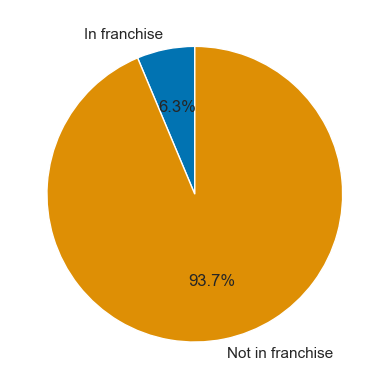

In [35]:
proportion = len(franchise_df) / len(movies_df)
proportions = pd.DataFrame({'Proportion': [proportion, 1 - proportion]}, index=['In franchise', 'Not in franchise'])
explode = (0, 0.1)
fig, ax = plt.subplots()
ax.pie(proportions['Proportion'], labels=proportions.index, autopct='%1.1f%%', startangle=90)

plt.show()

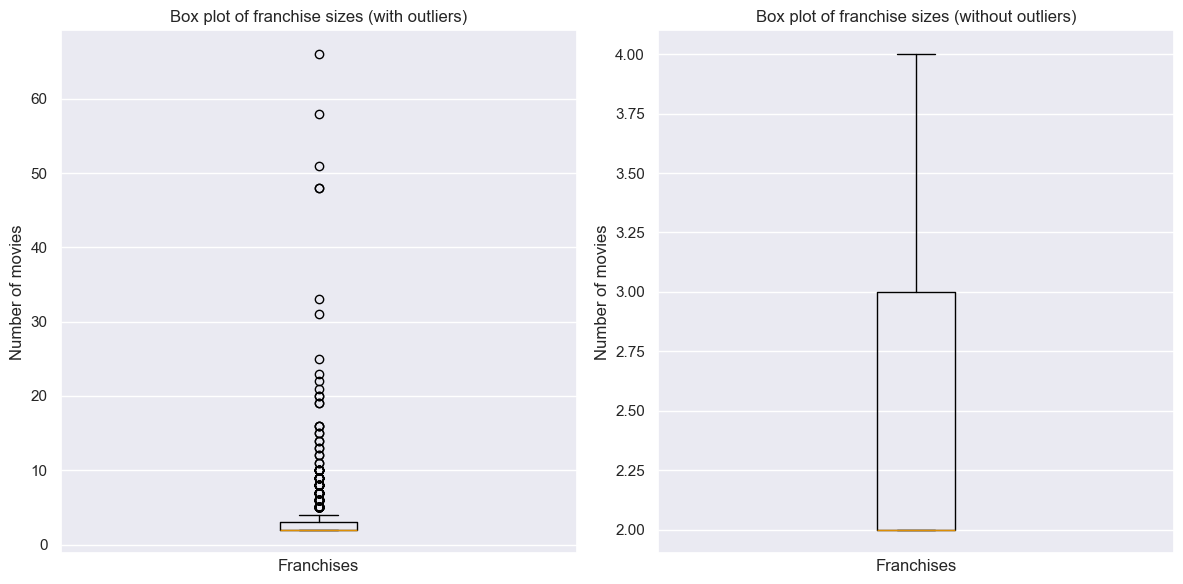

In [36]:
# Plot the box plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot with outliers
axes[0].boxplot(franchise_counts)
axes[0].set_title('Box plot of franchise sizes (with outliers)')
axes[0].set_ylabel('Number of movies')
axes[0].set_xlabel('Franchises')
axes[0].set_xticks([])

# Boxplot without outliers
axes[1].boxplot(franchise_counts, showfliers=False)
axes[1].set_title('Box plot of franchise sizes (without outliers)')
axes[1].set_ylabel('Number of movies')
axes[1].set_xlabel('Franchises')
axes[1].set_xticks([])

plt.tight_layout()
plt.show()

Here, we can see that at least 75% of the franchises have between 2 and 4 movies. And when looking closely at the outliers, such as "Our gang: The Roach/Pathé silents (1922-1928)" with 66 movies, we see that they mostly do not correspond to sequels, but to franchises. This is something to keep in mind for the data analysis.

### Focusing on genres

Now, we wanted to look more closely at the genre columns, as it is one of the parameters needed to answer our research questions. First, let's plot the genre proportions in the original dataset, with all the movies. 

N.B.: most movies are defined by multiple genres and not a unique one

In [37]:
# Calculate the total count of all genres
total_genres_count, genre_counts_df = get_genre_counts(movies_df_raw)
# Determine the threshold count for 2%
threshold_count = total_genres_count * 0.02
# Replace genres with counts below the threshold with an empty string for labels
labels = genre_counts_df.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)

# Plotting the pie chart with filtered labels
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 10))

ax1.pie(genre_counts_df['counts'], labels=labels, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax1.set_title('Distribution of Genres in dataset')

# Replace any genre containing "comedy" (case-insensitive) with "comedy"
genre_counts_df['genre'] = genre_counts_df['genre'].str.replace(r'(?i).*comedy.*', 'Comedy', regex=True)

# Group by genre and sum counts
old_genre_counts = genre_counts_df.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
labels2 = old_genre_counts.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)
# Plotting the pie chart
ax2.pie(old_genre_counts['counts'], labels=labels2, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax2.set_title('Distribution of Genres in dataset, comedies grouped')

# Replace genres with counts below the threshold with "other"
old_genre_counts['genre'] = old_genre_counts.apply(lambda row: 'other' if row['counts'] < threshold_count else row['genre'], axis=1)
old_genre_counts = old_genre_counts.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
# Plotting the pie chart
ax3.pie(old_genre_counts['counts'], labels=old_genre_counts['genre'], autopct='%1.1f%%')
ax3.set_title('Distribution of Genres in dataset, comedies grouped, with "other" category')

plt.show()

NameError: name 'get_genre_counts' is not defined

Now, let's compare with the distribution in the movies in franchises subset:

In [38]:
# Calculate the total count of all genres
total_genres_count = get_genre_counts(franchise_df)
# Determine the threshold count for 2%
threshold_count = total_genres_count * 0.02
# Replace genres with counts below the threshold with an empty string for labels
labels = genre_counts_df.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)

# Plotting the pie chart with filtered labels
fig = plt.figure(figsize=(21, 10))
gs = GridSpec(2, 3, height_ratios=[2, 1], width_ratios=[1, 1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax1.pie(genre_counts_df['counts'], labels=labels, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax1.set_title('Distribution of Genres in Collections')

# Replace any genre containing "comedy" (case-insensitive) with "comedy"
genre_counts_df['genre'] = genre_counts_df['genre'].str.replace(r'(?i).*comedy.*', 'Comedy', regex=True)


# Group by genre and sum counts
old_genre_counts = genre_counts_df.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
labels2 = old_genre_counts.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)
# Plotting the pie chart
ax2 = fig.add_subplot(gs[0, 1])
ax2.pie(old_genre_counts['counts'], labels=labels2, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax2.set_title('Distribution of Genres in Collections, comedies grouped')

# Replace genres with counts below the threshold with "other"
old_genre_counts['genre'] = old_genre_counts.apply(lambda row: 'other' if row['counts'] < threshold_count else row['genre'], axis=1)
old_genre_counts = old_genre_counts.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
# Plotting the pie chart
ax3 = fig.add_subplot(gs[0, 2])
ax3.pie(old_genre_counts['counts'], labels=old_genre_counts['genre'], autopct='%1.1f%%')
ax3.set_title('Distribution of Genres in Collections, comedies grouped, with "other" category')

# Extract top 5 and bottom 5 genres
top_5_genres = genre_counts_df.head(5)
bottom_5_genres = genre_counts_df.tail(5)
# Combine top 5 and bottom 5 genres into a single DataFrame
top_bottom_genres = pd.concat([top_5_genres, bottom_5_genres])

# Plot the table with top 5 and bottom 5 genres
ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')

# Create the table
table = ax4.table(cellText=top_bottom_genres.values,
                 colLabels=top_bottom_genres.columns,
                 cellLoc='center', loc='center')

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(12)  # Increase font size
table.scale(1.2, 1.5)  # Scale for better spacing

# Adding color to the header and rows
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold')  # Make header text bold
        cell.set_facecolor('#6a7ba2')  # Green background for header
        cell.set_text_props(color='white')  # White text color for the header
    else:
        if i % 2 == 0:
            cell.set_facecolor('#f2f2f2')  # Light gray color for alternate rows
        else:
            cell.set_facecolor('#ffffff')  # White color for other rows

    # Set border style
    cell.set_edgecolor('black')  # Add black borders to cells

# Display the table
plt.show()

NameError: name 'get_genre_counts' is not defined

Now, we know that there are a lot of unique, very specific and irrelevant genres in the original categories (such as "Kitchen sink realism"), that appear less than 2% and together represent 42% of the whole genres. We therefore chose to use the ones in the added TMDB dataset.

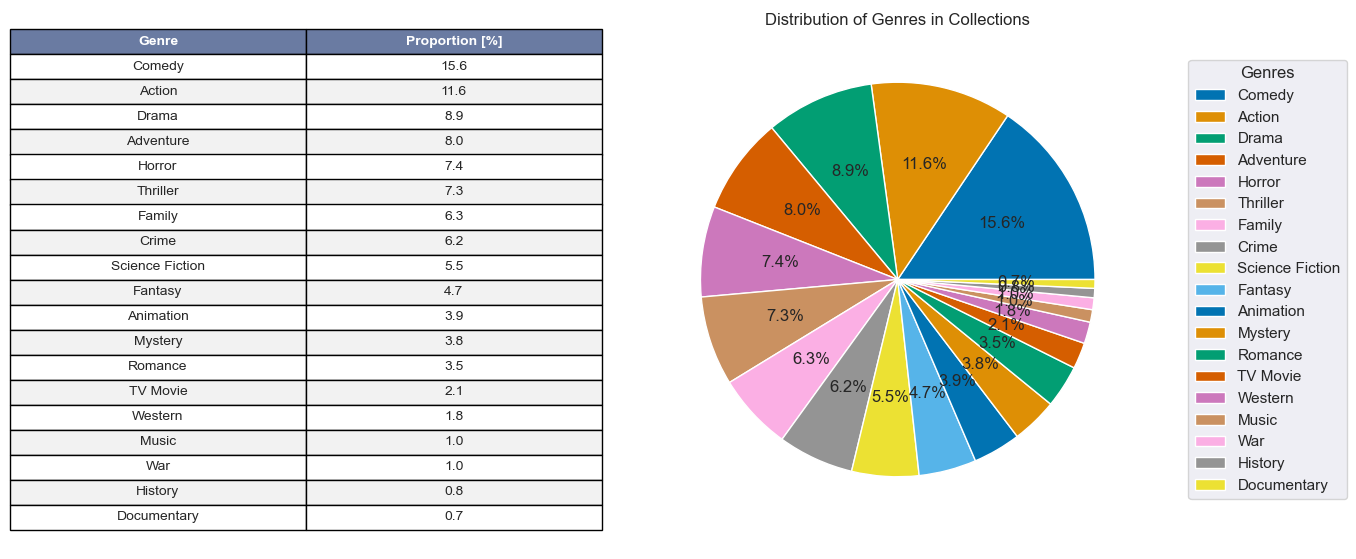

In [40]:
# Flatten the list of genres and count the occurrences
flattened_genres = [genre for sublist in franchise_df['genres'] for genre in sublist]
genre_counts = Counter(flattened_genres)

# Convert the Counter object to a DataFrame for easier plotting
genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count']).reset_index()
genre_counts_df.columns = ['genre', 'count']

# Calculate the proportion of each genre
genre_counts_df['proportion [%]'] = genre_counts_df['count'] / genre_counts_df['count'].sum() * 100
genre_counts_df = genre_counts_df.sort_values(by='proportion [%]', ascending=False)
genre_counts_df['proportion [%]'] = genre_counts_df['proportion [%]'].apply(lambda x: round(x, 1))

# Create a new figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plot the table with genre proportions
ax1.axis('off')
table = ax1.table(cellText=genre_counts_df[['genre', 'proportion [%]']].values,
                  colLabels=['Genre', 'Proportion [%]'],
                  cellLoc='center', loc='center')

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(12)  # Increase font size
table.scale(1.2, 1.5)  # Scale for better spacing

# Adding color to the header and rows
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold')  # Make header text bold
        cell.set_facecolor('#6a7ba2')  # Green background for header
        cell.set_text_props(color='white')  # White text color for the header
    else:
        if i % 2 == 0:
            cell.set_facecolor('#f2f2f2')  # Light gray color for alternate rows
        else:
            cell.set_facecolor('#ffffff')  # White color for other rows

    # Set border style
    cell.set_edgecolor('black')  # Add black borders to cells

# Plot the pie chart with labels only on the side
wedges, texts, autotexts = ax2.pie(genre_counts_df['count'], labels=['']*len(genre_counts_df), autopct='%1.1f%%')
ax2.legend(wedges, genre_counts_df['genre'], title="Genres", loc="center", bbox_to_anchor=(1, 0, 0.5, 1))
ax2.set_title('Distribution of Genres in Collections')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1., 1.)

plt.show()

This looks better ! And we still have the same top 3 genre ! Let's now compare our franchise movies to non franchise movies, to see if they seem to follow the same distribution:

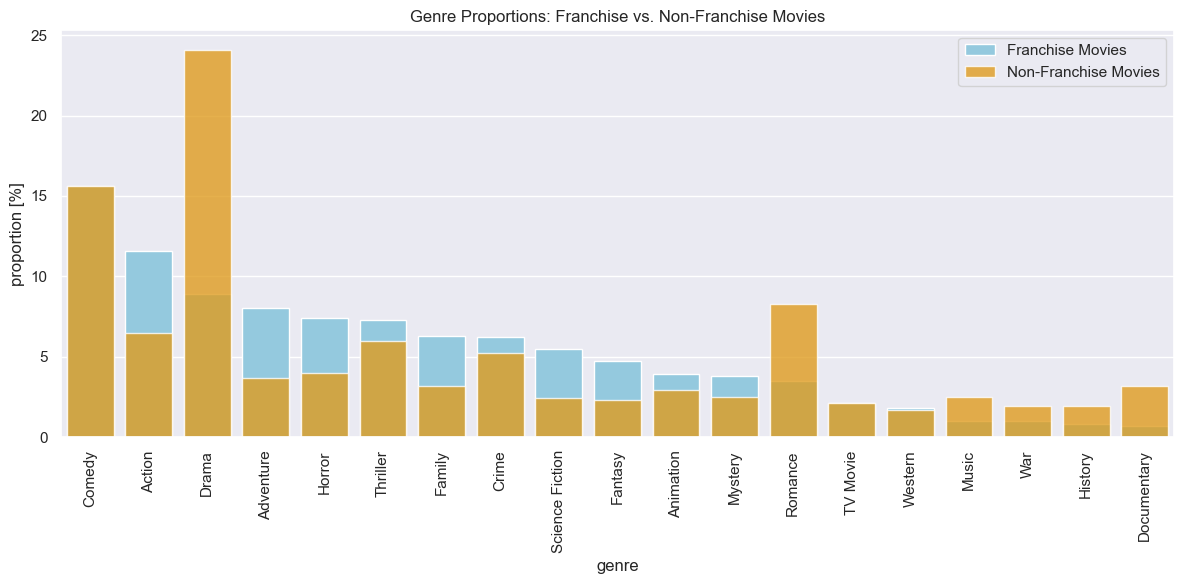

In [41]:
# Extract genres proportions for movies not in franchise, as done before
nf_flattened_genres = [genre for sublist in movies_df['genres'] for genre in sublist]
nf_genre_counts = Counter(nf_flattened_genres)
nf_genre_counts_df = pd.DataFrame.from_dict(nf_genre_counts, orient='index', columns=['count']).reset_index()
nf_genre_counts_df.columns = ['genre', 'count']
nf_genre_counts_df['proportion [%]'] = nf_genre_counts_df['count'] / nf_genre_counts_df['count'].sum() * 100
nf_genre_counts_df = nf_genre_counts_df.sort_values(by='proportion [%]', ascending=False)
nf_genre_counts_df['proportion [%]'] = nf_genre_counts_df['proportion [%]'].apply(lambda x: round(x, 1))

# Set up the figure
plt.figure(figsize=(12, 6))

# Plot the higher bars (franchise) first
sns.barplot(
    x="genre", y="proportion [%]", data=genre_counts_df,
    color="skyblue", label="Franchise Movies"
)

# Plot the lower bars (non-franchise) second
sns.barplot(
    x="genre", y="proportion [%]", data=nf_genre_counts_df,
    color="orange", alpha=0.8, label="Non-Franchise Movies"
)

# Add labels, legend, and rotate x-axis labels for better visibility
plt.xticks(rotation=90)
plt.legend()
plt.title("Genre Proportions: Franchise vs. Non-Franchise Movies")
plt.tight_layout()

plt.show()

Here, we can see that Dramas are a lot more present (three times more) in non-franchise movies than in franchise movies. Why is that ? Do the viewers lose interest when they are presented multiple dramas in a row ? If so, how would that translate ? In worse ratings ? Less box-office revenues ? Let's dive deeper into these questions, and try to understand the disparities between franchise and non-franchise movies, as well as understanding what makes a saga successful.

### Box office analysis 

In [42]:
franchise_df = franchise_df.dropna(subset=['Movie box office revenue'])
movies_df = movies_df.dropna(subset=['Movie box office revenue'])
print(franchise_df['collection_id'].value_counts())

KeyError: ['Movie box office revenue']

If we erase missing box office values in the franchise dataset, we can see that not all movies in a franchise have the box office revenue. For now, we'll use all the movies with box-office information in the franchise dataset, but we might remove them later on, when comparing revenue between the movies in a franchise. 

In [ ]:
movies_no_franchise = movies_df.copy()[movies_df['collection_id'].isna()]

Let's first look at the boxplot of revenue to know what we're working with.

In [ ]:
all_box= pd.DataFrame({
        'non-franchise movies': movies_no_franchise['Movie box office revenue'], #movie_box['Movie box office revenue'],
        'franchise movies': franchise_df['Movie box office revenue'] # box_office_df['Movie box office revenue']
        })
print(all_box.describe())
#Box plot to compare Movie box office in film that are in franchise and those that are not
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
# Plot with outliers
all_box.boxplot(ax=axes[0])
axes[0].set_title('Box plot with outliers')
    
# Plot without outliers
all_box.boxplot(ax=axes[1], showfliers=False)
axes[1].set_title('Box plot without outliers')
    
fig.text(0.04, 0.5, 'Box Office Revenue', va='center', rotation='vertical')
plt.suptitle('Comparison of Movie Box Office Revenue')
plt.tight_layout(rect=[0.04, 0, 1, 0.96])
plt.show()

In the first plot, we see that there are a lot of outliers. The other plot allows us to see more clearly the average and median box office revenue values. We see that franchises movies in general have a larger box office revenue then non franchise movies. 

In [ ]:
ax = sns.barplot(data=all_box)
plt.title('Bar chart of Movie Box Office Revenue')
plt.ylabel('Box Office Revenue')
plt.show()

# Perform independent (we assume they are) t-test (Welch's t-test, assuming unequal variances)
t_stat, p_value = stats.ttest_ind(all_box['franchise movies'].dropna(), all_box['non-franchise movies'].dropna(), equal_var=False)
print("T-test Results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4e}")
if p_value < 0.05:
    print("The difference in means is statistically significant (p < 0.05).")
else:
    print("The difference in means is not statistically significant (p >= 0.05).")

This graph is another visualisation then the one before that allows use to calculate the p-values. 

Now, let's analyse if a correlation exists beetween box office revenue and the movie budget. 

In [ ]:
#Formating the box office and budget values 
# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
# Plot the correlation matrix 
ax1.scatter(movies_no_franchise['budget'], movies_no_franchise['revenue'])
ax1.set_title("non-franchise movies")
ax1.set_xlabel('Budget')
ax1.set_ylabel('Box office revenue')

ax2.scatter(movies_df['budget'], movies_df['revenue'])
ax2.set_title("all movies")
ax2.set_xlabel('Budget')
ax2.set_ylabel('Box office revenue')

ax3.scatter(franchise_df['budget'], franchise_df['revenue'])
ax3.set_title("franchise movies")
ax3.set_xlabel('Budget')
ax3.set_ylabel('Box office revenue')

fig.suptitle('Scatter plot comparing box office revenue and budget ')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

def correlation_revenue_budget(df):
    # Calculate the correlation between 'budget' and 'revenue'
    numerical_df = df.select_dtypes(include='number').drop(columns=['ratio_box_budget','Freebase movie ID','Movie name','Movie release date','vote_count','release_year','run_time','nbr_movie_per_col','movie_order','tmdb_id','cote_count','vote_average','Movie runtime','Wikipedia movie ID','collection_name',	'collection_id','revenue'], errors='ignore')
    correlation_matrix = numerical_df.corr()
    return correlation_matrix

non_franchise_correlation=correlation_revenue_budget(movies_no_franchise)
movies_correlation=correlation_revenue_budget(movies_df)
franchise_correlation=correlation_revenue_budget(franchise_df)

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
# Plot the correlation matrix 
sns.heatmap(non_franchise_correlation, annot=True, cmap="coolwarm", fmt=".2f", ax=ax1)
ax1.set_title("non-franchise movies")

sns.heatmap(movies_correlation, annot=True, cmap="coolwarm", fmt=".2f", ax=ax2)
ax2.set_title("movies_correlation")

sns.heatmap(franchise_correlation, annot=True, cmap="coolwarm", fmt=".2f", ax=ax3)
ax3.set_title("franchise movies")

fig.suptitle('Correlation Matrices')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

There is a linear positive correlation between box office revenue and budget that increase in franchise movies. Next, we want to look at how these values change within a single franchise:

In [ ]:
franchise_df = franchise_df.dropna(subset=['revenue'])
franchise_df= franchise_df[franchise_df['revenue'] != 0]
movies_df= movies_df.dropna(subset=['revenue'])
movies_df = movies_df[movies_df['revenue'] != 0]

In [ ]:
#Formating the date in all the data set 
franchise_df['Movie release date corrected'] = pd.to_datetime(franchise_df['Movie release date'],format='mixed',yearfirst=True)
franchise_df['release_year'] = franchise_df['Movie release date corrected'].dt.year
movies_df['Movie release date'] = pd.to_datetime(movies_df['Movie release date'], errors='coerce')
movies_df['release_year'] = movies_df['Movie release date'].dt.year

franchise_df['movie_order']=franchise_df.groupby('collection_id')['release_year'].rank(ascending=True)
#cleaning the data 
franchise_df['release_year'].dropna()

#Formating the box office and budget values 
def scientific_notation(x):
    return "{:.2e}".format(x)

franchise_df['budget'] = pd.to_numeric(franchise_df['budget'])
franchise_df['Movie box office revenue'] = pd.to_numeric(franchise_df['Movie box office revenue'])

box_count = franchise_df['collection_id'].value_counts()
valid_box_id = box_count[box_count > 1].index
franchise_df = franchise_df[franchise_df['collection_id'].isin(valid_box_id)]

Now the data set is clean, we can compare movies box office and revenue that are in the same franchise, classified by year. 

In [ ]:
def collection_budget_box_1(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    df = df.sort_values(by='release_year')

    # Plot budget 
    for index, row in df.iterrows():
        ax1.plot(row['release_year'], row['budget'], marker='o',linestyle='-',label=row['Movie name'])

    f_budget = interp1d(df['release_year'], df['budget'], kind='linear')
    x_budget = np.linspace(df['release_year'].min(), df['release_year'].max(), 500)
    y_budget = f_budget(x_budget)
    ax1.plot(x_budget, y_budget, '-', label='Interpolated Budget')
    ax1.set_ylabel('Budget')
    ax1.set_xlabel('Release Year')
    ax1.set_title('Budget over Time')

    # Plot box office revenue 
    for index, row in df.iterrows():
        ax2.plot(row['release_year'], row['Movie box office revenue'], marker='o', linestyle='-',label=row['Movie name'])
    
    f_revenue = interp1d(df['release_year'], df['Movie box office revenue'], kind='linear')
    x_revenue = np.linspace(df['release_year'].min(), df['release_year'].max(), 500)
    y_revenue = f_revenue(x_revenue)
    ax2.set_ylabel('Box Office Revenue')
    ax2.plot(x_revenue, y_revenue, '-', label='Interpolated Revenue')
    ax2.set_xlabel('Release Year')
    ax2.set_title('Box Office Revenue over Time')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Set the main title for the figure
    fig.suptitle(f"{df['collection_name'].iloc[0]}")
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [ ]:
filtered_df = franchise_df[franchise_df['collection_id'] == 10]
collection_budget_box_1(filtered_df)

Here we plot the evolution through time of revenu and budget of movies in the franchise Star Wars. The goal is to create an interactive plot where you can choose the collection. 
Plus, to create an other interactive plot with the same information but as bar chart to be more readable. 


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
app = dash.Dash(__name__)
app.layout = html.Div([
    html.H4('Interactive collection selection with simple Dash example'),
    html.P("Select collection:"),
    dcc.Dropdown(
        id="dropdown",
        options=[{'label': name, 'value': name} for name in franchise_df['collection_name'].unique()],
        value='Star Wars Collection',
        clearable=False,
    ),
    dcc.Graph(id="graph"),
])


@app.callback(
    Output("graph", "figure"), 
    Input("dropdown", "value"))
def display_graph(collection_name):
    filtered_df = franchise_df[franchise_df['collection_name'] == collection_name].sort_values(by='release_year')
    filtered_df['release_year_int'] = filtered_df.loc[:,'release_year'].astype(int)
# Melt the DataFrame to have budget and revenue in a single column
    melted_df = filtered_df.melt(id_vars=['release_year_int', 'Movie name'], value_vars=['budget', 'revenue'], 
                             var_name='Value', value_name='Money [$]')
# Create an interactive plot using Plotly
    fig = px.bar(melted_df, x='release_year_int', y='Money [$]', color='Value', barmode="group",
             hover_data=['Movie name'], title=f'Budget and Revenue through time of the {filtered_df["collection_name"].iloc[0]}',
             labels={'release_year_int': 'Release Year', 'Money [$]': 'Money [$]', 'Value': 'Type'})
# Customize the layout
    fig.update_layout(
        xaxis=dict(
            tickmode='array', 
            tickvals=filtered_df['release_year_int'], 
            ticktext=[f'{year} {name}' for year, name in filtered_df[['release_year_int', 'Movie name']].values],
            tickangle=45
        ),
        legend_title_text='Value',
        autosize=False,
        width=1000,
        height=600
    )
    return fig

# Run the Dash app on a different port
if __name__ == '__main__':
    app.run_server(debug=True, port=8056)


In [ ]:
# Import libraries
import requests
from bs4 import BeautifulSoup
URL ='https://www.minneapolisfed.org/about-us/monetary-policy/inflation-calculator/consumer-price-index-1800-'
r = requests.get(URL)
page_body = r.text
soup = BeautifulSoup(page_body, 'html.parser')
table = soup.find('table')
table_rows = table.find_all('tr')
data = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
    data.append(row)
inflation_rate = pd.DataFrame(data, columns=["Year", "CPI","anuel_inflation_rate"])
# Drop the first row 
inflation_rate = inflation_rate.drop(0).reset_index(drop=True)

# Clean up the data by removing newline characters and extra spaces
inflation_rate['Year'] = inflation_rate['Year'].str.strip().str.replace('\n', '')
inflation_rate['CPI'] = inflation_rate['CPI'].str.strip().str.replace('\n', '').astype(float)
inflation_rate['anuel_inflation_rate'] = inflation_rate['anuel_inflation_rate'].str.strip().str.replace('\n', '')

inflation_rate['Year'] = pd.to_numeric(inflation_rate['Year'])
inflation_rate['CPI'] = pd.to_numeric(inflation_rate['CPI'])

franchise_df= pd.merge(franchise_df, inflation_rate['CPI'], how='left', left_on=franchise_df['release_year'], right_on=inflation_rate['Year'])



#base year 2024
#Real Price=Nominal Price×CPI in Base Year/ CPI in Year of Price
#Year 2 Price = Year 1 Price x (Year 2 CPI/Year 1 CPI)

# Find the CPI corresponding to the year 2024
base_year_cpi= inflation_rate.loc[inflation_rate['Year'] == 2024, 'CPI'].iloc[0]
#print(base_year_cpi)

franchise_df['real_revenue']= franchise_df['revenue']*base_year_cpi/franchise_df['CPI'].iloc[0]
franchise_df['real_budget']= franchise_df['budget']*base_year_cpi/franchise_df['CPI'].iloc[0]

### Year Repartition (from the release date colomn)

#### initialisation for the year partition part

In [ ]:
movies_df = pd.read_csv('data/movie_metadata_with_tmdb.csv')
movies_df['Movie release date corrected'] = pd.to_datetime(movies_df['Movie release date'], format='mixed', yearfirst=True, errors='coerce')
movies_df['release_year'] = movies_df['Movie release date corrected'].dt.year


franchise_df=get_franchise_movies(movies_df)
franchise_data_df = get_franchise_data(franchise_df)

In this section, we visualize the distribution of movies over the years to compare whether the CMU dataset and the franchise dataset contain a similar distribution of movies across time.

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the histogram for franchise_df
ax1.hist(franchise_df['release_year'].dropna(), bins=range(int(franchise_df['release_year'].min()), int(franchise_df['release_year'].max()) + 1), edgecolor='black', alpha=0.5, label='franchise_df')
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Number of Movies in franchise_df', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for the movies_df histogram
ax2 = ax1.twinx()
ax2.hist(movies_df['release_year'].dropna(), bins=range(int(movies_df['release_year'].min()), int(movies_df['release_year'].max()) + 1), edgecolor='black', alpha=0.5, color='r', label='movies_df')
ax2.set_ylabel('Number of Movies in movies_df', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.title('Histogram of Number of Movies per Release Year')
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()
# Create a new figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the KDE for franchise_df
sns.kdeplot(franchise_df['release_year'].dropna(), ax=ax, label='franchise_df', color='blue')

# Plot the KDE for movies_df
sns.kdeplot(movies_df['release_year'].dropna(), ax=ax, label='movies_df', color='red')

# Set labels and title
ax.set_xlabel('Release Year')
ax.set_ylabel('Density')
ax.set_title('KDE Plot of Number of Movies per Release Year')
ax.legend()

plt.show()

Since the interactive plot does not work on the website version of GitHub, it was removed. However, the idea is to create a timeline displaying all the franchises, with options to sort, filter, and adjust color hues to emphasize specific categories of franchises and provide a clearer overview of the data.

In this part we're gonna investigate the distribution of length and of number of movies in the dataset

In [ ]:
# Count the number of collection of same length
franchise_data_df_counts = franchise_data_df['franchise_length_years'].value_counts().reset_index()
franchise_data_df_counts.columns = ['franchise_length_years', 'count']
# Plotting the bar chart
fig, ax = plt.subplots()
ax.bar(franchise_data_df_counts['franchise_length_years'], franchise_data_df_counts['count'])
ax.set_xlabel('Collection Length in Years')
ax.set_ylabel('Count')
ax.set_title('Distribution of Collection Lengths in Years')
plt.show()

# Show the outliers for a length of 40 years and more
outliers = franchise_data_df[franchise_data_df['franchise_length_years'] >= 40]
outliers[['collection_name', 'franchise_length_years']]

In [ ]:
# Count the number of collection with the same number of movies
franchise_data_df_counts = franchise_data_df['movie_count'].value_counts().reset_index()
franchise_data_df_counts.columns = ['movie_count', 'count']

# Show the outliers for a number of movies of 20 and more
outliers = franchise_data_df[franchise_data_df['movie_count'] >= 20]
outliers[['collection_name', 'movie_count']]

We see that most of the franchise have 2 movies, which could be sequel of 2 movies but also be an original movie with a remake or an additional movie of a side story, to try to separate them, we try to normalize this length and number of movie distribution

In [ ]:
# Normalize the length by the number of movies
franchise_data_df['franchise_length_normalized'] = franchise_data_df['franchise_length_years'] / franchise_data_df['movie_count']

# Count the number of collection with the same normalized length
franchise_data_df_counts = franchise_data_df['franchise_length_normalized'].value_counts().reset_index()
franchise_data_df_counts.columns = ['franchise_length_normalized', 'count']

# Plotting the bar chart
fig, ax = plt.subplots()
ax.bar(franchise_data_df_counts['franchise_length_normalized'], franchise_data_df_counts['count'])
ax.set_xlabel('Normalized Collection Length in Years')
ax.set_ylabel('Count')
ax.set_title('Distribution of Normalized Collection Lengths in Years')
plt.show()

# Show the outliers for a normalized length of 15 years and more
print("Outliers (Normalized Length >= 16 years):")
print(franchise_data_df[franchise_data_df['franchise_length_normalized'] >= 16][['collection_name', 'franchise_length_normalized']])

# Show the 10 first where the normalized length under 5 years
print("\nFirst 10 (Normalized Length < 5 years):")
print(franchise_data_df[franchise_data_df['franchise_length_normalized'] < 5].head(10)[['collection_name', 'franchise_length_normalized']])

Now show the average vote score per collection for different normalized years values

In [ ]:
# violin plot of the average vote by length in years with 8 bashes for 0,1,2,3,4,5,6 and more than 6 years
franchise_data_df['franchise_length_years_binned'] = pd.cut(franchise_data_df['franchise_length_years'], bins=[0, 1, 2, 3, 4, 5, 6, np.inf], labels=['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6+'])
# Calculate the mean and standard deviation of average_score for each franchise_length_years_binned
length_stats = franchise_data_df.groupby('franchise_length_years_binned')['average_score'].agg(['mean', 'std']).reset_index()

# Plot the line with error bars
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(length_stats['franchise_length_years_binned'], length_stats['mean'], yerr=length_stats['std'], fmt='-o', capsize=5)
ax.set_xlabel('Franchise Length in Years')
ax.set_ylabel('Average Vote')
ax.set_title('Average Vote by Franchise Length in Years with Error Bars')
ax.set_ylim(0, 10)
plt.show()

In [ ]:
# violin plot of the average vote by length in years with 8 bashes for 0,1,2,3,4,5,6 and more than 6 years
franchise_data_df['franchise_normalized_length_years_binned'] = pd.cut(franchise_data_df['franchise_length_normalized'], bins=[0, 1, 2, 3, 4, 5, 6, np.inf], labels=['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6+'])
# Calculate the mean and standard deviation of average_score for each franchise_normalized_length_years_binned
length_stats = franchise_data_df.groupby('franchise_normalized_length_years_binned')['average_score'].agg(['mean', 'std']).reset_index()

# Plot the line with error bars
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(length_stats['franchise_normalized_length_years_binned'], length_stats['mean'], yerr=length_stats['std'], fmt='-o', capsize=5)
ax.set_xlabel('Franchise Normalized Length in Years')
ax.set_ylabel('Average Vote')
ax.set_title('Average Vote by Franchise Normalized Length in Years with Error Bars')
ax.set_ylim(0, 10)
plt.show()

Now we can also investigate the score for each movie in a collection according to their order of release

In [ ]:
# add a collmn with the numerotation of the movies in the collection by release date order
franchise_df['movie_order'] = franchise_df.groupby('collection_name')['Movie release date corrected'].rank(method='first')

In [ ]:
# violin plot of the average vote for the movie order with 8 bashes for 0,1,2,3,4,5,6 and more than 6th movie
franchise_df['movie_order_binned'] = pd.cut(franchise_df['movie_order'], bins=[0, 1, 2, 3, 4, 5, 6, np.inf], labels=['1st', '2nd', '3rd', '4th', '5th', '6th', '6th+'])
# Calculate the mean and standard deviation of vote_average for each movie_order_binned
order_stats = franchise_df.groupby('movie_order_binned')['vote_average'].agg(['mean', 'std']).reset_index()

# Plot the line with error bars
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(order_stats['movie_order_binned'], order_stats['mean'], yerr=order_stats['std'], fmt='-o', capsize=5)
ax.set_xlabel('Number of the movie in the collection')
ax.set_ylabel('Average Vote')
ax.set_title('Average Vote by movie number in the collection with Error Bars')
ax.set_ylim(0, 10)
plt.show()

Now we can also compare the distribution of the vote score in franchise with a good overall review and ones with a worse overal review

In [ ]:
# kde plot of the average vote for all the franchise

fig, ax = plt.subplots(figsize=(10, 6))
average_vote = franchise_df[franchise_df['vote_average'] > 0]['vote_average'].median()
ax.axvline(average_vote, color='r', linestyle='--', label=f'Median: {average_vote:.2f}')
sns.kdeplot(franchise_df[franchise_df['vote_average'] > 0]['vote_average'].dropna(), ax=ax, label='franchise_df', color='blue')
ax.set_xlabel('Average Vote')
ax.set_ylabel('Density')
ax.set_title('KDE Plot of Average Vote for all the franchise')
ax.legend()
plt.show()

In [ ]:
# Filter the data for collections with average scores less than 6.1
low_score_df = franchise_df[(franchise_df['vote_average'] < average_vote) & (franchise_df['vote_average'] > 0)]

# Filter the data for collections with average scores more than 6.1
high_score_df = franchise_df[franchise_df['vote_average'] > average_vote]

# Bin the movie order for both dataframes using .loc to avoid the SettingWithCopyWarning
low_score_df.loc[:, 'movie_order_binned'] = pd.cut(low_score_df['movie_order'], bins=[0, 1, 2, 3, 4, 5, 6, np.inf], labels=['1st', '2nd', '3rd', '4th', '5th', '6th', '6th+'])
high_score_df.loc[:, 'movie_order_binned'] = pd.cut(high_score_df['movie_order'], bins=[0, 1, 2, 3, 4, 5, 6, np.inf], labels=['1st', '2nd', '3rd', '4th', '5th', '6th', '6th+'])

# Calculate the mean and standard deviation of vote_average for each movie_order_binned
low_score_stats = low_score_df.groupby('movie_order_binned')['vote_average'].agg(['mean', 'std']).reset_index()
high_score_stats = high_score_df.groupby('movie_order_binned')['vote_average'].agg(['mean', 'std']).reset_index()

# Plot the line with error bars for both low and high score collections
fig, ax = plt.subplots(figsize=(10, 6))

# Plot low score collections
ax.errorbar(low_score_stats['movie_order_binned'], low_score_stats['mean'], yerr=low_score_stats['std'], fmt='-o', capsize=5, label='Score < 6.1')

# Plot high score collections
ax.errorbar(high_score_stats['movie_order_binned'], high_score_stats['mean'], yerr=high_score_stats['std'], fmt='-o', capsize=5, label='Score > 6.1')

ax.set_xlabel('Number of the movie in the collection')
ax.set_ylabel('Average Vote')
ax.set_title('Average Vote by movie number in the collection with Error Bars')
ax.set_ylim(0, 10)
ax.legend()
plt.show()


### Looking at the Countries of Origin

Now, we want to focus on the franchises' countries of origin (using the tmdb dataset), and look at how they interact. First we plotted a pie chart to get a first look at which countries are most respresented in the dataset.

In [ ]:

# Clean the categories and normalize the data
def clean_categories(category_string):
    # Remove brackets and quotes
    cleaned_category=category_string.replace("[","").replace("]","").replace("'","").split(", ")
    # Return category list
    return cleaned_category


# Initialize a defaultdict to hold category sums
country_sums = defaultdict(int)

# Iterate over the rows of the DataFrame
for _, row in franchise_df.iterrows():
    # Clean the categories
    origin_country_new = clean_categories(row['tmdb_origin_country'])
    # Increment the count for each category
    for country in origin_country_new:
        country_sums[country] += 1

# Convert the defaultdict to a DataFrame
country_count = pd.Series(country_sums)

# Only keep countries with more than 10 movies
others=country_count[country_count<150].sum()
country_count=country_count[country_count>=150]
country_count['Others']=others

# Plot the pie chart
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(country_count, autopct='%1.1f%%', pctdistance=1.1, startangle=90)
ax.legend(wedges, country_count.index, title="Countries", loc="center", bbox_to_anchor=(1, 0, 0.5, 1))
ax.set_title('Distribution of Origin Countries in Franchise movies')
# Add the text under the pie chart
info_text = "'US'=='United States of America' ; 'HK'=='Hong Kong' ; 'CA'=='Canada' ; 'IN'=='India' ; 'GB'=='Great Britain' ; 'JP'=='Japan'"
fig.text(0.5, 0.01, info_text, ha='center', va='center', fontsize=10, wrap=True)
plt.tight_layout()
plt.show()

Now, let's look at how they interact: the nodes in the plot below represent how often the country is the origin of a movie, and the edges indicate that two countries are listed together as the origin countries.

In [ ]:
from src.utils.plotting import plot_network
plot_network(franchise_df)

## Character data analysis

### Data loading and preprocessing

First, we load the character data, and drop rows with missing values in any of the following columns:

```
['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date','Actor_gender' 'Actor_name', 'Freebase_character_actor_map_ID', 'Freebase_actor_ID']
```

Note that `clean_character_metadata` also creates `ethnicity` and `racial_group` columns. For more details, please refer to `data/utils.py`.

In [ ]:
col_names = [
    'Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Character_name', 
    'Actor_date_of_birth', 'Actor_gender', 'Actor_height_m', 'Actor_ethnicity_Freebase_ID', 
    'Actor_name', 'Actor_age_at_movie_release', 'Freebase_character_actor_map_ID', 
    'Freebase_character_ID', 'Freebase_actor_ID'
]
character_df = pd.read_csv('data/character.metadata.tsv', names=col_names, sep='\t')
character_df = clean_character_metadata(character_df, mapping_path="data/ethnicity_mapping.csv") # cleaned character data
movie_df = pd.read_csv("data/movie_metadata_with_tmdb.csv") # all tmdb-enriched movie meta data
franchise_df = get_franchise_movies(movie_df) # franchise movies
# Filter out movies that are not in the franchise
fr_character_df = character_df[character_df['Wikipedia_movie_ID'].isin(franchise_df['Wikipedia movie ID'])]

### Grasping the data

#### On gender

In the context of diversity and inclusion, what interests us the most is gender and ethnicity distribution of actors. Let's first check if gender distribution in franchise movies is similar to that of set of all of our movies.

In [ ]:
# Calculate the proportion of each gender for character_df
gender_proportion_all = character_df['Actor_gender'].value_counts()

# Calculate the proportion of each gender for fr_character_df
gender_proportion_franchise = fr_character_df['Actor_gender'].value_counts()

# Plot the gender proportions as pie charts side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot for character_df
gender_proportion_all.plot(kind='pie', ax=axes[0], autopct=custom_autopct(gender_proportion_all),
                           startangle=90, labels=['Male', 'Female'], colors=['#1f77b4', '#feb5da'], fontsize=14)
axes[0].set_ylabel('')
axes[0].set_title('All movies', fontsize=20)

# Plot for fr_character_df
gender_proportion_franchise.plot(kind='pie', ax=axes[1], autopct=custom_autopct(gender_proportion_franchise),
                                 startangle=90, labels=['Male', 'Female'], colors=['#1f77b4', '#feb5da'],
                                 fontsize=14)
axes[1].set_ylabel('')
axes[1].set_title('Franchise movies', fontsize=20)

# Set overarching title
fig.suptitle('Gender distribution comparison', fontsize=24)

plt.show()

It seems that franchise movies have similar proportion of female actors, so that we can do analysis on the influence of gender on both franchise and non-franchise movies.

#### On ethnicity

For what percentage of the actors the ethnicity information is available?

From the pie chart below, it seems that this is available for only 1/4 of the actors. However, after observing the data, these actors with known ethnicity tend to play main roles in the film. For us, this justify to conduct analysis on only available ethnicity data.

In [ ]:
ethnicity_counts = character_df['ethnicity'].notnull().value_counts()
ethnicity_labels = ['Ethnicity Unknown', 'Ethnicity Known']

# Plot the pie chart
fig, ax = plt.subplots()
ax.pie(ethnicity_counts, labels=ethnicity_labels, autopct=custom_autopct(ethnicity_counts), startangle=90, colors=['#1f77b4', '#ff7f0e'])
ax.set_title('Proportion of Actors with Ethnicity Entries', fontsize=14)
plt.show()

As shown in below, some of the ethnicity categories are very specific which might not be suitable for group-level analysis. We manually mapped these ethnicity categories to 7 racial groups, as exlained in the `README.md`.

In [ ]:
character_df.ethnicity.dropna().reset_index()[:10]

The plot below shows

(Left): Count of ethnicity category on log-scale. If you pay attention to the y-axis, we notice that there are more than 400 ethnicity categories.

(Right): Extracting the top-30 categories from the plot on the left.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot the current figure on the left
ax1 = character_df.groupby("ethnicity").size().sort_values(ascending=True).plot(
    kind='barh', ax=axes[0], logx=True, width=1, edgecolor='none')
ax1.set_title("Number of characters per ethnicity (log scale)", fontsize=14)
ax1.set_yticks(range(0, len(character_df['ethnicity'].value_counts()), 50))
ax1.set_yticklabels(range(0, len(character_df['ethnicity'].value_counts()), 50), rotation=0)
ax1.set_xlabel("Number of characters (log scale)")
ax1.set_ylabel("Ethnicity")

# Plot the top 30 ethnicities on the right
top_30_ethnicities = character_df['ethnicity'].value_counts().nlargest(30)
ax2 = top_30_ethnicities.sort_values(ascending=True).plot(
    kind='barh', ax=axes[1], width=.5)
ax2.set_title("Top 30 ethnicities by number of characters", fontsize=14)
ax2.set_xlabel("Number of characters")
ax2.set_ylabel("Ethnicity")

plt.tight_layout()
plt.show()

Next, we'll look at the distribution of racial groups in our movie sets.

In [ ]:
character_df["racial_group"]
value_counts = character_df["racial_group"].value_counts()
value_counts.plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
plt.title('Distribution of Racial Groups', fontsize=14)
plt.xlabel('Racial Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

We observe that white people are the largest group among the actors where ethnicity information is available. In the next step, we combine this ethnicity/racial group information with actor casting and tabular data analysis to reveal the influence of ethnic identity in the movie world.